# <center>PHY408 Final Report: <br> Youth Unemployment and Median Wages, 2001 – 2023</center>

<center>Spencer Y. Ki<br>Prof. D. Jones<br>PHY408H1S<br>Wednesday, the 26th of April, 2023.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Introduction & Motivation

The rise of the 'gig economy' has been a boon to employers looking to cut costs, but the trend has also led to a spike in employment precarity among the corresponding temporary labourers. Among no demographic is this more pronounced than with young workers. While finding 'gig work' is easy, young workers have been struggling to secure well-paying, stable jobs that provide benefits and opportunities for advancement. This leaves them particularly vulnerable when labour costs become untenable for employers to sustain.

This dynamic has been rising over the past few decades — Statistics Canada has found that youth employment has been becoming more precarious since the late 1980s. However, the trend became particularly distinct during the past few years dominated by COVID-19. Although employees of all ages suffered from negative job growth, the economic downturn disproportionately affected young workers in comparison to their older peers, with youth unemployment levels rising roughly 100% more compared to other age groups over the pandimc.

But just how quantitatively linked are the costs of labour and youth employment rates? Although there are innumerable economic factors that can affect this relationship, there are two that are easily compared and examined using time series analysis methods: average hourly wages and the youth unemployment rate. So just how are they linked exactly?

## Analysis & Results
### Data sourcing and cleaning

The youth unemployment rate was simple to source, given that Statistics Canada partitions its monthly labour force characteristics report by age group. As such, for the purposes of this analysis "youth" or "young workers" refers to StatsCan's "15 to 14 years" age group. As a first dataset, the youth unemployment rate from January 2001 to February 2023 was collected from StatsCan.

Obtaining meaningful cost of labour data required slightly more forethough. StatsCan does collect a significant amount of data on employee compensation, but just comparing youth unemployment to the general average wage would not yield particularly meaningful results. Given that the focus of this analysis is precarity, the average hourly earnings for employees paid by the hour was selected as the best metric to measure against, as salaried employees would be more likely to be in permanent positions. Median was selected as the measure of "average," and overtime pay was excluded. This data was also collected from January 2001 to February 2023.

Of course, unadjuted wages have only been increasing over the past few years due to steady inflation. Accordingly, real wages were calculated by sourcing monthly consumer price index data from StatsCan and adjusting for inflation since January 2001.

From here, one can plot the above data to view a raw comparison between real wages and youth unemployment:

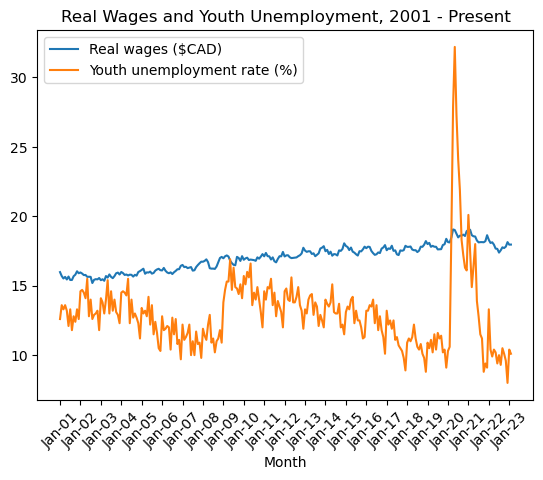

In [2]:
# Load data
dat = np.loadtxt("unemployment_data.csv", delimiter = ",",
                 skiprows = 1, usecols = (1, 2, 3), unpack = True)
month = np.loadtxt("unemployment_data.csv", dtype = str, delimiter = ",",
                   skiprows = 1, usecols = 0, unpack = True)
cpi = dat[0]
wages = dat[1]
unemploy = dat[2]

# Inflation adjust
cpi_2001 = cpi / 96.3 * 100
adj_wages = wages / cpi_2001 * 100

# Unadjusted plot
plt.figure()
plt.plot(month, adj_wages, label = "Real wages ($CAD)")
plt.plot(month, unemploy, label = "Youth unemployment rate (%)")
plt.xlabel("Month")
plt.title("Real Wages and Youth Unemployment, 2001 - Present")
plt.legend()
plt.xticks(month[::12], rotation = 45)
plt.show()

### Detrending
As aforementioned, a number of economic factors affect the relationship between real wages and youth unemployment. Global financial crises are certainly a major one, and one that has a distinctly noticable in the above plot — note the spike in youth unemployment that occurs after the 2008 financial crisis and during the beginning of the COVID-19 pandemic. To correct for these factors, both datasets were detrended: the real wage data with a first-degree polynomial and the unemployment data with a sixth-degree polynomial. The detrended plots in comparison to the raw data can be observed here:

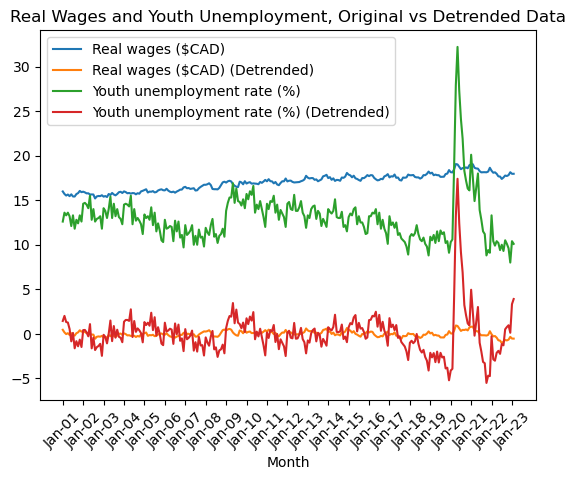

In [3]:
# Detrend
num_month = np.arange(len(month))
wages_trend = np.polyfit(num_month, adj_wages, 1)
wages_detrend = adj_wages - np.polyval(wages_trend, num_month)
unemploy_trend = np.polyfit(num_month, unemploy, 6)
unemploy_detrend = unemploy - np.polyval(unemploy_trend, num_month)

# Detrended plot
plt.figure()
plt.plot(month, adj_wages, label = "Real wages ($CAD)")
plt.plot(month, wages_detrend, label = "Real wages ($CAD) (Detrended)")
plt.plot(month, unemploy, label = "Youth unemployment rate (%)")
plt.plot(month, unemploy_detrend, label = "Youth unemployment rate (%) (Detrended)")
plt.xlabel("Month")
plt.title("Real Wages and Youth Unemployment, Original vs Detrended Data")
plt.legend()
plt.xticks(month[::12], rotation = 45)
plt.show()

### Filtering
Another confounding economic factor is the idea of seasonal employment. This particularly affects youth, who are more likely to be working in the summer and winter when educational institutions are on break. To account for this, an f-domain filter was employed on the detrended data, with frequencies examined at the annual level. Accordingly, frequencies with an absolute value under 0.9 where filtered out, to not account for employment fluctuations within a year. This filtering can be observed in the plot below:

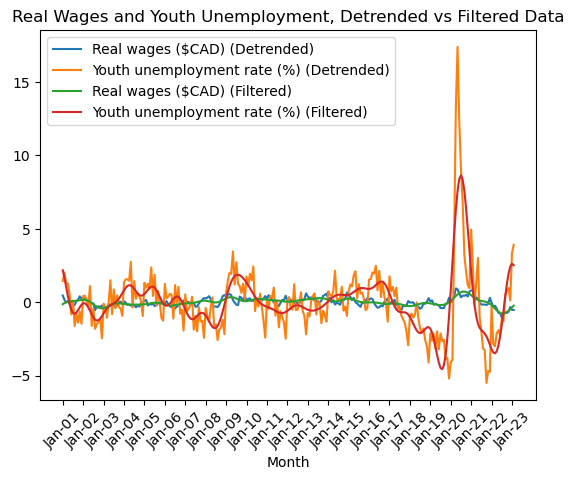

In [4]:
# F-domain filter
wages_ft = np.fft.fft(wages_detrend)
unemploy_ft = np.fft.fft(unemploy_detrend)
f = np.fft.fftfreq(len(wages_detrend), 1/12)

wages_ft_an = wages_ft
wages_ft_an[(f > 0.9) | (f < -0.9)] = 0
unemploy_ft_an = unemploy_ft
unemploy_ft_an[(f > 0.9) | (f < -0.9)] = 0

wages_filter = np.real(np.fft.ifft(wages_ft_an))
unemploy_filter = np.real(np.fft.ifft(unemploy_ft_an))

#wages_retrend = wages_filter + np.polyval(wages_trend, num_month)
#unemploy_retrend = unemploy_filter + np.polyval(unemploy_trend, num_month)

# Filter plot
plt.figure()
plt.plot(month, wages_detrend, label = "Real wages ($CAD) (Detrended)")
plt.plot(month, unemploy_detrend, label = "Youth unemployment rate (%) (Detrended)")
plt.plot(month, wages_filter, label = "Real wages ($CAD) (Filtered)")
plt.plot(month, unemploy_filter, label = "Youth unemployment rate (%) (Filtered)")
plt.xlabel("Month")
plt.title("Real Wages and Youth Unemployment, Detrended vs Filtered Data")
plt.legend()
plt.xticks(month[::12], rotation = 45)
plt.show()

### Cross-Correlation
Finally, the filtered data was cross-correlated to observe their relationship. The filtered wage data was selected as the reference series while the filtered unemployment data was selected as the comparison series. This cross-correlation was plotted here:

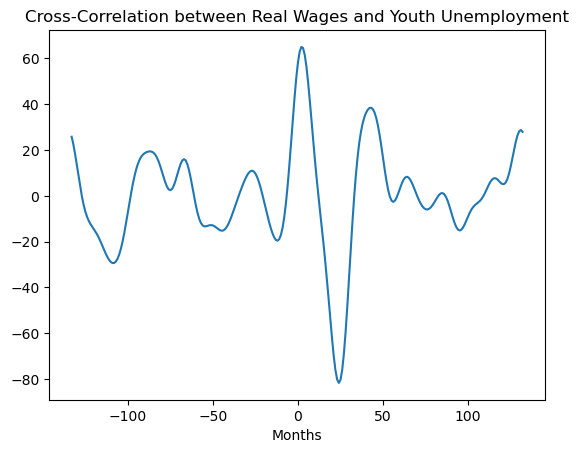

In [5]:
# Cross-correlation
wages_ft_2 = np.fft.fft(wages_filter)
unemploy_ft_2 = np.fft.fft(unemploy_filter)
cross_corr = np.fft.fftshift(np.fft.ifft(wages_ft_2 * np.conj(unemploy_ft_2)))
t = np.arange(-len(wages_ft_2)/2, len(wages_ft_2)/2)

# Cross-corr plot
plt.figure()
plt.plot(t, np.real(cross_corr))
plt.xlabel("Months")
plt.title("Cross-Correlation between Real Wages and Youth Unemployment")
plt.show()

## Discussion & Conclusion

As can be seen in the cross-correlation plot above, there is a significant peak roughly at 0 months and a significant trough at roughly 25 months. The peak suggests an immediate response in unemployment to wage growth, providing support for the idea that younger employees are the first 'on the chopping block' when wages become untenable. The trough at 25 months is suggestive, indicating that it may take employers roughly two years to account for increased labour costs (or that, after two years, inflation has caught up to any increased labour costs).

Unfortunately, there are many confounding factors that prevent one from drawing a causal link between real wage growth and youth unemployment. Of particular note is the fact that the data on wages isn't age-discriminated, limiting its applicability to a youth-focused analysis. Additionally, one should acknowledge that wages are rarely *cut*, with real wage decline largely due to nominal wage stagnation coupled with inflation. Accordingly, the relationship between real wage decline (which is a long-term phenomenon) and the youth unemployment rate (which responds very quickly to the economic environment) likely isn't direct, instead being correlated via a number of other factors.

Beyond the cross-correlation, what is noticeable in the filtered data plot is how unchanging real wages have been over the past quarter-century, especially in comparison to the wildly fluctuating (although admittedly periodic) unemployment rate. It is well known that real cost of living has steadily increased, and the relationship between stagnating wages and cost of living bears potential for future analysis.

## References

- Morissette, René. (2021). Chapter 2: Youth employment in Canada. *Portrait of Youth in Canada: Data Report.*
- Statistics Canada. (2023). *Table 14-10-0022-01  Labour force characteristics by industry, monthly, unadjusted for seasonality* [Data table]. https://doi.org/10.25318/1410002201-eng
- Statistics Canada. (2023). *Table 14-10-0205-01  Average hourly earnings for employees paid by the hour, by industry, monthly, unadjusted for seasonality* [Data table]. https://doi.org/10.25318/1410020501-eng
- Statistics Canada. (2023). *Table 18-10-0004-01  Consumer Price Index, monthly, not seasonally adjusted* [Data table]. https://doi.org/10.25318/1810000401-eng